🔗 **Links**

* 📂 **GitHub Repository**: [do-small-llm-research](https://github.com/vukrosic/do-small-llm-research)
* 📄 **Paper PDF**: [15-Minute Pretraining Ablations](https://github.com/vukrosic/do-small-llm-research/blob/main/15min_llm_ablations_paper.pdf)

# Explanation

## 🔬 What This Notebook Is All About

This notebook is a **complete framework for running an ablation study** on a small Transformer-based language model. In simple terms, it:

> ✅ **Trains the same model multiple times**,
> 🔁 **Changes one thing at a time** (like model size, learning rate, batch size),
> 📊 **Tracks how each change affects performance**, and
> 🧪 **Collects and visualizes all results for comparison**.

This is super helpful for understanding what design choices actually matter when training models.

---

Since all of you are at a different knowledge level, I left it up to you to copy unfamiliar code into ChatGPT and ask for explanations.

---

## 🔧 1. **Setup**

```python
!pip install --upgrade datasets
```

Installs the `datasets` library from Hugging Face, which is used to load the training data.

---

## 🧠 2. **Training Script**

This is the **core engine** of the notebook. It contains everything needed to define, train, and evaluate a small Transformer language model called `MinimalLLM`.

### Key Components:

* **Model definition**: A tiny Transformer model tailored for easy experimentation.
* **Data loading**: Uses `load_smollm_corpus` and `TextTokenDataset` to fetch and tokenize training data.
* **Metrics tracking**: A class called `EnhancedMetricsTracker` records:

  * Training loss
  * Accuracy
  * Perplexity
  * Validation stats
* **Training loop**: `train_with_comprehensive_logging()` runs training with:

  * Gradient clipping
  * Mixed-precision (AMP) for speed
  * Logging and evaluation checkpoints
* **Ablation configs**: The `COLAB_ABLATIONS` dictionary defines multiple training setups like:

  * Smaller model
  * Larger batch size
  * Higher/lower learning rate
  * Shorter context window
* **Main experiment runner**: `run_colab_ablations()` trains the model under **each configuration**, saves results, and prints generated text samples for quick comparison.

---

## 📦 3. **Research Data Collector**

This step organizes everything you need to **publish or analyze your experiment**:

* Collects logs, metrics, and generated texts from each ablation
* Saves summaries to CSV and Markdown files
* Packages everything into a `.zip` for download (`research_data.zip`)

This is especially useful if you plan to include the results in a research paper or blog post.

---

## 🗃️ 4. **Check What Data We Have**

A quick script to confirm that:

* Each ablation run has its own folder
* Key output files like `metrics.json` exist
  This is like a sanity check before visualization.

---

## 📈 5. **Fixed Plotting**

The `FixedAblationPlotter` class loads all metrics and creates helpful plots like:

* Loss/accuracy vs. training steps
* Final performance of each configuration
* Training efficiency comparisons

These plots help you **understand which changes improved the model** and which didn’t.

---

## 🧩 Summary

### This notebook does **everything** needed for a reproducible ablation study:

| Step                 | Purpose                                                            |
| -------------------- | ------------------------------------------------------------------ |
| Install dependencies | Ensure required libraries are available                            |
| Define and train     | Implement and train the Transformer model under different settings |
| Track metrics        | Log detailed performance and efficiency stats                      |
| Collect results      | Organize and save everything (metrics, samples, logs)              |
| Visualize outcomes   | Generate graphs to compare how each config affects performance     |
| Package for sharing  | Prepare everything for research reuse or publication               |

---

## 🧪 What Is an Ablation Study, Really?

An **ablation study** means you:

> Change one variable at a time (like removing a feature or tweaking a hyperparameter),
> Train the model again,
> And **see how performance changes**.

It’s how researchers figure out **what parts of a model or training setup really matter**.


# Code

In [ ]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

Run training ablations

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import math
import pickle
from datasets import load_dataset
import regex
from tqdm import tqdm
import os
import json
import time
import numpy as np
from collections import defaultdict
from transformers import AutoTokenizer

# Copy all your original classes here
def load_smollm_corpus(num_documents=500):
    """Load SmolLM corpus data for autoregressive training"""
    print(f"Loading HuggingFaceTB/smollm-corpus dataset (cosmopedia-v2)...")
    tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M", token=False)
    dataset = load_dataset("HuggingFaceTB/smollm-corpus", "cosmopedia-v2", split="train", streaming=True, token=False)

    texts = []
    for i, item in enumerate(dataset):
        if i >= num_documents:
            break
        texts.append(item["text"])

    print(f"Loaded {len(texts)} documents")
    total_tokens = sum(len(tokenizer.encode(text)) for text in texts)
    print(f"Total tokens: {total_tokens:,}")
    print(f"Average tokens per document: {total_tokens / len(texts):.1f}")

    return texts, tokenizer

class TextTokenDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len=512):
        self.tokenizer = tokenizer
        self.seq_len = seq_len

        print("Tokenizing texts...")
        all_tokens = []
        for text in tqdm(texts, desc="Tokenizing"):
            tokens = tokenizer.encode(text)
            all_tokens.extend(tokens)

        self.tokens = all_tokens
        print(f"Total tokens after concatenation: {len(self.tokens):,}")

    def __len__(self):
        return len(self.tokens) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.tokens[idx:idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.tokens[idx + 1:idx + self.seq_len + 1], dtype=torch.long)
        return x, y

class Rotary(nn.Module):
    def __init__(self, dim: int, max_seq_len: int):
        super().__init__()
        angular_freq = (1 / 1024) ** torch.linspace(0, 1, steps=dim//4, dtype=torch.float32)
        angular_freq = torch.cat([angular_freq, angular_freq.new_zeros(dim//4)])
        t = torch.arange(max_seq_len, dtype=torch.float32)
        theta = torch.einsum("i,j -> ij", t, angular_freq)
        self.register_buffer('cos', theta.cos(), persistent=False)
        self.register_buffer('sin', theta.sin(), persistent=False)

    def forward(self, x_BTHD: torch.Tensor):
        assert self.cos.size(0) >= x_BTHD.size(-3)
        cos, sin = self.cos[None, :x_BTHD.size(-3), None, :], self.sin[None, :x_BTHD.size(-3), None, :]
        x1, x2 = x_BTHD.to(dtype=torch.float32).chunk(2, dim=-1)
        y1 = x1 * cos + x2 * sin
        y2 = x1 * (-sin) + x2 * cos
        return torch.cat((y1, y2), 3).type_as(x_BTHD)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, max_seq_len):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.qkv = nn.Linear(d_model, d_model * 3, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        self.rotary = Rotary(self.d_k, max_seq_len)

    def forward(self, x, mask=None):
        batch_size, seq_len = x.size(0), x.size(1)

        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.n_heads, self.d_k)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        Q, K, V = qkv[0], qkv[1], qkv[2]

        Q = self.rotary(Q)
        K = self.rotary(K)

        attn_output = F.scaled_dot_product_attention(Q, K, V, is_causal=True, dropout_p=0.0)
        attn_output = attn_output.transpose(1, 2).reshape(batch_size, seq_len, self.d_model)
        return self.w_o(attn_output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff, bias=False)
        self.linear2 = nn.Linear(d_ff, d_model, bias=False)

    def forward(self, x):
        return self.linear2(F.silu(self.linear1(x)))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, max_seq_len):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, max_seq_len)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.RMSNorm(d_model)
        self.norm2 = nn.RMSNorm(d_model)

    def forward(self, x, mask=None):
        attn_out = self.attention(self.norm1(x), mask)
        x = x + attn_out
        ff_out = self.feed_forward(self.norm2(x))
        x = x + ff_out
        return x

class MinimalLLM(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=8, n_layers=6, d_ff=1024, max_len=512):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, max_len) for _ in range(n_layers)
        ])
        self.norm = nn.RMSNorm(d_model)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x):
        seq_len = x.size(1)
        mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0).to(x.device)

        x = self.token_embedding(x) * math.sqrt(self.d_model)

        for block in self.transformer_blocks:
            x = block(x, mask)

        x = self.norm(x)
        logits = F.linear(x, self.token_embedding.weight)
        return logits

    def generate(self, tokenizer, prompt_tokens, max_new_tokens=50, temperature=0.8):
        """Generate text given a prompt"""
        self.eval()
        with torch.no_grad():
            tokens = prompt_tokens.copy()

            for _ in range(max_new_tokens):
                # Get last max_len tokens
                input_tokens = tokens[-self.max_len:]
                x = torch.tensor(input_tokens).unsqueeze(0)

                if torch.cuda.is_available():
                    x = x.cuda()

                # Forward pass with autocast for inference
                with autocast('cuda'):
                    logits = self(x)
                logits = logits[0, -1, :] / temperature

                # Sample next token
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, 1).item()
                tokens.append(next_token)

        return tokenizer.decode(tokens)

# Enhanced Metrics Tracker
class EnhancedMetricsTracker:
    def __init__(self, save_dir="training_logs"):
        self.metrics = defaultdict(list)
        self.save_dir = save_dir
        self.start_time = time.time()
        os.makedirs(save_dir, exist_ok=True)

    def log_step(self, step, **kwargs):
        """Log metrics for a single step"""
        # Always ensure step and timestamp are logged for every metric
        for key, value in kwargs.items():
            if key not in self.metrics:
                self.metrics[key] = []
            self.metrics[key].append(value)

            # Ensure corresponding step tracking for each metric
            step_key = f"{key}_steps"
            if step_key not in self.metrics:
                self.metrics[step_key] = []
            self.metrics[step_key].append(step)

            # Ensure corresponding timestamp for each metric
            time_key = f"{key}_timestamps"
            if time_key not in self.metrics:
                self.metrics[time_key] = []
            self.metrics[time_key].append(time.time() - self.start_time)

    def save_metrics(self, filename="metrics.json"):
        """Save all metrics to JSON"""
        filepath = os.path.join(self.save_dir, filename)
        with open(filepath, 'w') as f:
            json.dump(dict(self.metrics), f, indent=2)
        print(f"💾 Metrics saved to {filepath}")

    def get_latest(self, metric_name, default=None):
        """Get the latest value of a metric"""
        if metric_name in self.metrics and self.metrics[metric_name]:
            return self.metrics[metric_name][-1]
        return default

def calculate_advanced_metrics(model, logits, targets, loss):
    """Calculate comprehensive training metrics"""
    with torch.no_grad():
        # Basic metrics
        predictions = logits.argmax(dim=-1)
        accuracy = (predictions == targets).float().mean().item()
        perplexity = math.exp(min(loss.item(), 20))

        # Token-level metrics
        total_tokens = targets.numel()
        correct_tokens = (predictions == targets).sum().item()

        # Confidence metrics
        probs = F.softmax(logits, dim=-1)
        max_probs = probs.max(dim=-1)[0]
        avg_confidence = max_probs.mean().item()

        # Entropy (measure of uncertainty) - use more stable calculation
        # Clamp probabilities to avoid log(0) and use a larger epsilon
        probs_clamped = torch.clamp(probs, min=1e-8, max=1.0)
        log_probs = torch.log(probs_clamped)
        entropy = -(probs * log_probs).sum(dim=-1).mean().item()

        # Additional safety check for NaN
        if math.isnan(entropy) or math.isinf(entropy):
            entropy = 0.0

        # Top-k accuracy (top-5)
        top5_correct = 0
        for i in range(targets.size(0)):
            for j in range(targets.size(1)):
                target_token = targets[i, j].item()
                top5_preds = logits[i, j].topk(5)[1].tolist()
                if target_token in top5_preds:
                    top5_correct += 1
        top5_accuracy = top5_correct / total_tokens

        return {
            'accuracy': accuracy,
            'perplexity': perplexity,
            'avg_confidence': avg_confidence,
            'entropy': entropy,
            'top5_accuracy': top5_accuracy,
            'total_tokens': total_tokens,
            'correct_tokens': correct_tokens
        }

def generate_text_samples(model, tokenizer, config_name):
    """Generate text samples with different prompts"""
    print(f"\n🎯 Generating text samples for {config_name}...")

    # Test prompts covering different domains
    test_prompts = [
        "The future of artificial intelligence",
        "In a world where technology",
        "Scientists have discovered",
        "The most important lesson in life",
        "Once upon a time in a distant"
    ]

    model.eval()
    samples = {}

    for i, prompt in enumerate(test_prompts):
        print(f"\n📝 Prompt {i+1}: '{prompt}'")

        # Tokenize prompt
        prompt_tokens = tokenizer.encode(prompt)

        # Generate text
        try:
            generated_text = model.generate(
                tokenizer,
                prompt_tokens,
                max_new_tokens=40,
                temperature=0.8
            )

            # Extract just the generated part
            generated_part = generated_text[len(prompt):].strip()
            full_text = prompt + generated_part

            print(f"Generated: {full_text}")
            samples[f"prompt_{i+1}"] = {
                "prompt": prompt,
                "generated": full_text,
                "generated_only": generated_part
            }

        except Exception as e:
            print(f"❌ Generation failed: {e}")
            samples[f"prompt_{i+1}"] = {
                "prompt": prompt,
                "generated": f"[Generation failed: {e}]",
                "generated_only": ""
            }

    model.train()
    return samples

def get_model_analysis(model):
    """Get detailed model analysis"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Parameter statistics by layer type
    layer_stats = defaultdict(lambda: {'params': 0, 'mean': 0, 'std': 0})

    for name, param in model.named_parameters():
        if param.requires_grad:
            layer_type = name.split('.')[0] if '.' in name else name
            layer_stats[layer_type]['params'] += param.numel()
            layer_stats[layer_type]['mean'] += param.data.mean().item() * param.numel()
            layer_stats[layer_type]['std'] += param.data.std().item() * param.numel()

    # Normalize by parameter count
    for layer_type in layer_stats:
        if layer_stats[layer_type]['params'] > 0:
            layer_stats[layer_type]['mean'] /= layer_stats[layer_type]['params']
            layer_stats[layer_type]['std'] /= layer_stats[layer_type]['params']

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'layer_stats': dict(layer_stats)
    }

def evaluate_model(model, dataloader, device, vocab_size, max_batches=20):
    """Comprehensive model evaluation"""
    model.eval()
    total_loss = 0
    all_metrics = defaultdict(list)

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            if i >= max_batches:
                break

            x, y = x.to(device), y.to(device)

            with autocast('cuda'):
                logits = model(x)
                loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))

            # Calculate comprehensive metrics
            metrics = calculate_advanced_metrics(model, logits, y, loss)

            total_loss += loss.item()
            for key, value in metrics.items():
                all_metrics[key].append(value)

    # Average all metrics
    eval_metrics = {}
    eval_metrics['eval_loss'] = total_loss / min(len(dataloader), max_batches)

    for key, values in all_metrics.items():
        if key not in ['total_tokens', 'correct_tokens']:  # Skip count metrics
            eval_metrics[f'eval_{key}'] = np.mean(values)

    model.train()
    return eval_metrics

def train_with_comprehensive_logging(config_name="baseline", custom_config=None):
    """Enhanced training with comprehensive metrics logging"""

    # Default configuration
    config = {
        'seq_len': 512,
        'd_model': 384,
        'n_heads': 6,
        'n_layers': 12,
        'd_ff': 384*4,
        'batch_size': 8,
        'learning_rate': 3e-4,
        'epochs': 1,
        'warmup_steps': 1000,
        'cooldown_frac': 0.4,

        'eval_every': 400,
        'use_amp': True,
        'num_documents': 500,
        'max_steps': 2000,  # Limit for Colab
    }

    # Override with custom config
    if custom_config:
        config.update(custom_config)

    print(f"🚀 Starting training: {config_name}")
    print(f"📋 Config: {config}")

    # Initialize metrics tracker
    tracker = EnhancedMetricsTracker(save_dir=f"training_logs/{config_name}")

    # Load data
    texts, tokenizer = load_smollm_corpus(num_documents=config['num_documents'])
    vocab_size = tokenizer.vocab_size

    # Create datasets
    dataset = TextTokenDataset(texts, tokenizer, config['seq_len'])

    # Split into train/val
    val_size = len(dataset) // 10
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Initialize model
    model = MinimalLLM(
        vocab_size=vocab_size,
        d_model=config['d_model'],
        n_heads=config['n_heads'],
        n_layers=config['n_layers'],
        d_ff=config['d_ff'],
        max_len=config['seq_len']
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Compile model
    try:
        model = torch.compile(model, mode='default')
        print("✅ Model compiled successfully!")
    except Exception as e:
        print(f"⚠️ torch.compile failed: {e}")

    # Get model analysis
    model_analysis = get_model_analysis(model)
    print(f"📊 Total parameters: {model_analysis['total_params']:,}")

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=0.1,
        fused=True
    )

    total_steps = min(len(train_loader) * config['epochs'], config['max_steps'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=total_steps, eta_min=config['learning_rate'] * 0.1
    )

    scaler = GradScaler('cuda') if config['use_amp'] else None

    # Training loop
    model.train()
    step = 0
    best_eval_loss = float('inf')

    print(f"🎯 Starting training for {total_steps} steps...")

    for epoch in range(config['epochs']):
        epoch_start_time = time.time()

        for batch_idx, (x, y) in enumerate(train_loader):
            if step >= config['max_steps']:
                break

            step_start_time = time.time()

            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            # Forward pass
            if config['use_amp']:
                with autocast('cuda'):
                    logits = model(x)
                    loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                logits = model(x)
                loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
                loss.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            scheduler.step()
            step_time = time.time() - step_start_time

            # Always log basic metrics
            basic_metrics = {
                'train_loss': loss.item(),
                'learning_rate': scheduler.get_last_lr()[0],
                'grad_norm': grad_norm.item(),
                'step_time': step_time,
            }
            tracker.log_step(step, **basic_metrics)

            # Calculate comprehensive metrics for evaluation and step 0
            if step % config['eval_every'] == 0 or step == 0:
                train_metrics = calculate_advanced_metrics(model, logits, y, loss)
                # Log comprehensive metrics with proper step tracking
                tracker.log_step(step, **train_metrics)

            # Evaluation (including step 0 for baseline)
            if step % config['eval_every'] == 0:
                print(f"\n📊 Step {step} - Evaluating...")
                eval_metrics = evaluate_model(model, val_loader, device, vocab_size)

                # Log evaluation metrics with proper step tracking
                tracker.log_step(step, **eval_metrics)

                # Track best model (no saving)
                if eval_metrics['eval_loss'] < best_eval_loss:
                    best_eval_loss = eval_metrics['eval_loss']

                print(f"✅ Eval - Loss: {eval_metrics['eval_loss']:.4f}, "
                      f"Acc: {eval_metrics['eval_accuracy']:.3f}, "
                      f"PPL: {eval_metrics['eval_perplexity']:.2f}")

            # Save metrics periodically
            if step % 500 == 0 and step > 0:
                tracker.save_metrics()
                print(f"💾 Saved metrics at step {step}")

            step += 1

        if step >= config['max_steps']:
            break

        epoch_time = time.time() - epoch_start_time
        print(f"📊 Epoch {epoch+1} completed in {epoch_time:.1f}s")

    # Generate text samples at the end
    print(f"\n{'='*60}")
    print(f"🎨 TEXT GENERATION SAMPLES - {config_name.upper()}")
    print(f"{'='*60}")

    text_samples = generate_text_samples(model, tokenizer, config_name)

    # Save text samples to file
    samples_file = f"training_logs/{config_name}/text_samples.json"
    with open(samples_file, 'w') as f:
        json.dump(text_samples, f, indent=2)
    print(f"💾 Text samples saved to {samples_file}")

    # Final save (metrics only)
    tracker.save_metrics()

    print(f"✅ Training completed: {config_name}")
    return model, tracker

# Ablation configurations for Colab T4
COLAB_ABLATIONS = {
    'baseline': {},

    'small_model': {
        'd_model': 256,
        'n_heads': 4,
        'n_layers': 8,
        'd_ff': 256*4,
        'batch_size': 12,  # Can fit more
    },

    'high_lr': {
        'learning_rate': 1e-3,
    },

    'low_lr': {
        'learning_rate': 1e-4,
    },

    'large_batch': {
        'batch_size': 16,
        'learning_rate': 5e-4,  # Scale with batch size
    },

    'short_seq': {
        'seq_len': 256,
        'batch_size': 12,
    },
}

def run_colab_ablations():
    """Run ablations suitable for Colab T4"""
    results = {}

    for config_name, custom_config in COLAB_ABLATIONS.items():
        print(f"\n{'='*60}")
        print(f"🔬 ABLATION: {config_name.upper()}")
        print(f"{'='*60}")

        try:
            model, tracker = train_with_comprehensive_logging(config_name, custom_config)
            results[config_name] = tracker

            # Clear GPU memory
            del model
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"❌ Failed ablation {config_name}: {e}")
            torch.cuda.empty_cache()
            continue

    print(f"\n🎉 Completed {len(results)} ablations!")
    return results

# For Colab usage - comment/uncomment what you want to run:

# Single baseline training
# model, tracker = train_with_comprehensive_logging()

# Run all ablations
results = run_colab_ablations()


🔬 ABLATION: BASELINE
🚀 Starting training: baseline
📋 Config: {'seq_len': 512, 'd_model': 384, 'n_heads': 6, 'n_layers': 12, 'd_ff': 1536, 'batch_size': 8, 'learning_rate': 0.0003, 'epochs': 1, 'warmup_steps': 1000, 'cooldown_frac': 0.4, 'eval_every': 400, 'use_amp': True, 'num_documents': 500, 'max_steps': 2000}
Loading HuggingFaceTB/smollm-corpus dataset (cosmopedia-v2)...


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Loaded 500 documents
Total tokens: 366,493
Average tokens per document: 733.0
Tokenizing texts...


Tokenizing: 100%|██████████| 500/500 [00:00<00:00, 513.68it/s]


Total tokens after concatenation: 366,493
✅ Model compiled successfully!
📊 Total parameters: 40,117,632
🎯 Starting training for 2000 steps...

📊 Step 0 - Evaluating...
✅ Eval - Loss: 10.3978, Acc: 0.033, PPL: 32802.34

📊 Step 400 - Evaluating...
✅ Eval - Loss: 5.4837, Acc: 0.210, PPL: 242.48
💾 Metrics saved to training_logs/baseline/metrics.json
💾 Saved metrics at step 500

📊 Step 800 - Evaluating...
✅ Eval - Loss: 4.6499, Acc: 0.261, PPL: 105.59
💾 Metrics saved to training_logs/baseline/metrics.json
💾 Saved metrics at step 1000

📊 Step 1200 - Evaluating...
✅ Eval - Loss: 4.1611, Acc: 0.291, PPL: 64.90
💾 Metrics saved to training_logs/baseline/metrics.json
💾 Saved metrics at step 1500

📊 Step 1600 - Evaluating...
✅ Eval - Loss: 3.8516, Acc: 0.322, PPL: 47.68

🎨 TEXT GENERATION SAMPLES - BASELINE

🎯 Generating text samples for baseline...

📝 Prompt 1: 'The future of artificial intelligence'
Generated: The future of artificial intelligence, and the complex project depicted in the Roman R

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Loaded 500 documents
Total tokens: 366,493
Average tokens per document: 733.0
Tokenizing texts...


Tokenizing: 100%|██████████| 500/500 [00:01<00:00, 417.81it/s]


Total tokens after concatenation: 366,493
✅ Model compiled successfully!
📊 Total parameters: 18,878,720
🎯 Starting training for 2000 steps...

📊 Step 0 - Evaluating...
✅ Eval - Loss: 10.6156, Acc: 0.015, PPL: 40769.31

📊 Step 400 - Evaluating...
✅ Eval - Loss: 5.6300, Acc: 0.204, PPL: 280.48
💾 Metrics saved to training_logs/small_model/metrics.json
💾 Saved metrics at step 500

📊 Step 800 - Evaluating...
✅ Eval - Loss: 4.8911, Acc: 0.251, PPL: 133.98
💾 Metrics saved to training_logs/small_model/metrics.json
💾 Saved metrics at step 1000

📊 Step 1200 - Evaluating...
✅ Eval - Loss: 4.4527, Acc: 0.278, PPL: 86.17
💾 Metrics saved to training_logs/small_model/metrics.json
💾 Saved metrics at step 1500

📊 Step 1600 - Evaluating...
✅ Eval - Loss: 4.2102, Acc: 0.297, PPL: 67.62

🎨 TEXT GENERATION SAMPLES - SMALL_MODEL

🎯 Generating text samples for small_model...

📝 Prompt 1: 'The future of artificial intelligence'
Generated: The future of artificial intelligenceand airtight full of the world. Yo

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Loaded 500 documents
Total tokens: 366,493
Average tokens per document: 733.0
Tokenizing texts...


Tokenizing: 100%|██████████| 500/500 [00:00<00:00, 502.22it/s]


Total tokens after concatenation: 366,493
✅ Model compiled successfully!
📊 Total parameters: 40,117,632
🎯 Starting training for 2000 steps...

📊 Step 0 - Evaluating...
✅ Eval - Loss: 10.2770, Acc: 0.075, PPL: 29066.93

📊 Step 400 - Evaluating...
✅ Eval - Loss: 5.3321, Acc: 0.202, PPL: 209.27
💾 Metrics saved to training_logs/high_lr/metrics.json
💾 Saved metrics at step 500

📊 Step 800 - Evaluating...
✅ Eval - Loss: 4.3246, Acc: 0.258, PPL: 76.88
💾 Metrics saved to training_logs/high_lr/metrics.json
💾 Saved metrics at step 1000

📊 Step 1200 - Evaluating...
✅ Eval - Loss: 3.4633, Acc: 0.330, PPL: 32.51
💾 Metrics saved to training_logs/high_lr/metrics.json
💾 Saved metrics at step 1500

📊 Step 1600 - Evaluating...
✅ Eval - Loss: 2.8514, Acc: 0.411, PPL: 17.72

🎨 TEXT GENERATION SAMPLES - HIGH_LR

🎯 Generating text samples for high_lr...

📝 Prompt 1: 'The future of artificial intelligence'
Generated: The future of artificial intelligenceand understanding the marine biome by the marine biome.

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Loaded 500 documents
Total tokens: 366,493
Average tokens per document: 733.0
Tokenizing texts...


Tokenizing: 100%|██████████| 500/500 [00:01<00:00, 315.73it/s]


Total tokens after concatenation: 366,493
✅ Model compiled successfully!
📊 Total parameters: 40,117,632
🎯 Starting training for 2000 steps...

📊 Step 0 - Evaluating...
✅ Eval - Loss: 10.6384, Acc: 0.015, PPL: 41708.54

📊 Step 400 - Evaluating...
✅ Eval - Loss: 6.1849, Acc: 0.187, PPL: 489.15
💾 Metrics saved to training_logs/low_lr/metrics.json
💾 Saved metrics at step 500

📊 Step 800 - Evaluating...
✅ Eval - Loss: 5.6361, Acc: 0.215, PPL: 282.31
💾 Metrics saved to training_logs/low_lr/metrics.json
💾 Saved metrics at step 1000

📊 Step 1200 - Evaluating...
✅ Eval - Loss: 5.3463, Acc: 0.230, PPL: 210.94
💾 Metrics saved to training_logs/low_lr/metrics.json
💾 Saved metrics at step 1500

📊 Step 1600 - Evaluating...
✅ Eval - Loss: 5.1800, Acc: 0.244, PPL: 178.56

🎨 TEXT GENERATION SAMPLES - LOW_LR

🎯 Generating text samples for low_lr...

📝 Prompt 1: 'The future of artificial intelligence'
Generated: The future of artificial intelligenceby incorporating elements into deeper into modern issues 

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Loaded 500 documents
Total tokens: 366,493
Average tokens per document: 733.0
Tokenizing texts...


Tokenizing: 100%|██████████| 500/500 [00:01<00:00, 499.44it/s]


Total tokens after concatenation: 366,493
✅ Model compiled successfully!
📊 Total parameters: 40,117,632
🎯 Starting training for 2000 steps...

📊 Step 0 - Evaluating...
✅ Eval - Loss: 10.2753, Acc: 0.059, PPL: 29010.86

📊 Step 400 - Evaluating...
✅ Eval - Loss: 4.6654, Acc: 0.257, PPL: 106.88
💾 Metrics saved to training_logs/large_batch/metrics.json
💾 Saved metrics at step 500

📊 Step 800 - Evaluating...
✅ Eval - Loss: 3.4280, Acc: 0.351, PPL: 30.95
💾 Metrics saved to training_logs/large_batch/metrics.json
💾 Saved metrics at step 1000

📊 Step 1200 - Evaluating...
✅ Eval - Loss: 2.3881, Acc: 0.518, PPL: 10.93
💾 Metrics saved to training_logs/large_batch/metrics.json
💾 Saved metrics at step 1500

📊 Step 1600 - Evaluating...
✅ Eval - Loss: 1.6126, Acc: 0.687, PPL: 5.03

🎨 TEXT GENERATION SAMPLES - LARGE_BATCH

🎯 Generating text samples for large_batch...

📝 Prompt 1: 'The future of artificial intelligence'
Generated: The future of artificial intelligenceand machine learning. Who knew we ca

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Loaded 500 documents
Total tokens: 366,493
Average tokens per document: 733.0
Tokenizing texts...


Tokenizing: 100%|██████████| 500/500 [00:01<00:00, 497.05it/s]


Total tokens after concatenation: 366,493
✅ Model compiled successfully!
📊 Total parameters: 40,117,632
🎯 Starting training for 2000 steps...

📊 Step 0 - Evaluating...
✅ Eval - Loss: 10.3826, Acc: 0.026, PPL: 32303.15

📊 Step 400 - Evaluating...
✅ Eval - Loss: 5.5507, Acc: 0.209, PPL: 259.44
💾 Metrics saved to training_logs/short_seq/metrics.json
💾 Saved metrics at step 500

📊 Step 800 - Evaluating...
✅ Eval - Loss: 4.7650, Acc: 0.258, PPL: 118.08
💾 Metrics saved to training_logs/short_seq/metrics.json
💾 Saved metrics at step 1000

📊 Step 1200 - Evaluating...
✅ Eval - Loss: 4.2772, Acc: 0.295, PPL: 72.53
💾 Metrics saved to training_logs/short_seq/metrics.json
💾 Saved metrics at step 1500

📊 Step 1600 - Evaluating...
✅ Eval - Loss: 3.9793, Acc: 0.325, PPL: 53.80

🎨 TEXT GENERATION SAMPLES - SHORT_SEQ

🎯 Generating text samples for short_seq...

📝 Prompt 1: 'The future of artificial intelligence'
Generated: The future of artificial intelligencealgorithms, has significantly within their i

## Collect / compile data

There is automated download of the zip, but it will probably be a lot faster if you manually download every file instead of the zip.

In [ ]:
import json
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import zipfile
import shutil
from datetime import datetime
import base64
from io import BytesIO

class ResearchDataCollector:
    def __init__(self, training_logs_dir="training_logs", output_dir="research_package"):
        self.training_logs_dir = training_logs_dir
        self.output_dir = output_dir
        self.research_data = {
            'metadata': {},
            'experimental_setup': {},
            'results_summary': {},
            'detailed_metrics': {},
            'text_samples': {},
            'statistical_analysis': {},
            'visualizations': {}
        }

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

    def collect_all_data(self):
        """Main function to collect all research data"""
        print("🔬 Collecting comprehensive research data...")

        self._collect_metadata()
        self._collect_experimental_setup()
        self._collect_training_metrics()
        self._collect_text_samples()
        self._perform_statistical_analysis()
        self._generate_visualizations()
        self._create_results_summary()
        self._save_research_package()

        print("✅ Research data collection complete!")

    def _collect_metadata(self):
        """Collect experiment metadata"""
        self.research_data['metadata'] = {
            'collection_date': datetime.now().isoformat(),
            'experiment_type': 'Autoregressive Transformer Language Model Ablation Study',
            'platform': 'Google Colab',
            'hardware': 'Tesla T4 GPU',
            'framework': 'PyTorch',
            'total_configurations': 0,
            'training_duration_estimate': 'Variable per configuration'
        }

    def _collect_experimental_setup(self):
        """Document experimental configurations"""
        # Load configuration details from the training script
        configs = {
            'baseline': {
                'description': 'Standard configuration with balanced parameters',
                'seq_len': 512,
                'd_model': 384,
                'n_heads': 6,
                'n_layers': 12,
                'd_ff': 1536,
                'batch_size': 8,
                'learning_rate': 3e-4,
                'max_steps': 2000
            },
            'small_model': {
                'description': 'Reduced model size for efficiency comparison',
                'd_model': 256,
                'n_heads': 4,
                'n_layers': 8,
                'd_ff': 1024,
                'batch_size': 12
            },
            'high_lr': {
                'description': 'Higher learning rate experiment',
                'learning_rate': 1e-3
            },
            'low_lr': {
                'description': 'Lower learning rate experiment',
                'learning_rate': 1e-4
            },
            'large_batch': {
                'description': 'Larger batch size with scaled learning rate',
                'batch_size': 16,
                'learning_rate': 5e-4
            },
            'short_seq': {
                'description': 'Shorter sequence length for memory efficiency',
                'seq_len': 256,
                'batch_size': 12
            }
        }

        self.research_data['experimental_setup'] = {
            'dataset': {
                'name': 'HuggingFaceTB/smollm-corpus (cosmopedia-v2)',
                'num_documents': 500,
                'tokenizer': 'HuggingFaceTB/SmolLM-135M',
                'preprocessing': 'Concatenated tokenization with sliding window'
            },
            'model_architecture': {
                'type': 'Autoregressive Transformer',
                'attention_mechanism': 'Multi-head attention with RoPE',
                'activation': 'SiLU (Swish)',
                'normalization': 'RMSNorm',
                'positional_encoding': 'Rotary Position Embedding (RoPE)'
            },
            'training_setup': {
                'optimizer': 'AdamW with weight decay 0.1',
                'scheduler': 'Cosine Annealing with warmup',
                'mixed_precision': 'Automatic Mixed Precision (AMP)',
                'gradient_clipping': 1.0,
                'evaluation_frequency': 'Every 400 steps'
            },
            'configurations': configs
        }

    def _collect_training_metrics(self):
        """Collect and process all training metrics"""
        detailed_metrics = {}

        if not os.path.exists(self.training_logs_dir):
            print(f"⚠️ Training logs directory {self.training_logs_dir} not found")
            return

        for config_dir in glob.glob(f"{self.training_logs_dir}/*/"):
            config_name = os.path.basename(config_dir.rstrip('/'))
            metrics_file = os.path.join(config_dir, "metrics.json")

            if os.path.exists(metrics_file):
                with open(metrics_file, 'r') as f:
                    raw_metrics = json.load(f)

                # Process metrics for research paper
                processed_metrics = self._process_metrics(raw_metrics)
                detailed_metrics[config_name] = processed_metrics

                print(f"✅ Processed metrics for {config_name}")

        self.research_data['detailed_metrics'] = detailed_metrics
        self.research_data['metadata']['total_configurations'] = len(detailed_metrics)

    def _process_metrics(self, raw_metrics):
        """Process raw metrics into research-ready format"""
        processed = {
            'training_progression': {},
            'final_performance': {},
            'convergence_analysis': {},
            'efficiency_metrics': {}
        }

        # Training progression (key metrics over time)
        for metric in ['train_loss', 'eval_loss', 'accuracy', 'perplexity']:
            if metric in raw_metrics:
                values = [v for v in raw_metrics[metric] if v is not None]
                if values:
                    processed['training_progression'][metric] = {
                        'initial': values[0] if values else None,
                        'final': values[-1] if values else None,
                        'min': min(values) if values else None,
                        'max': max(values) if values else None,
                        'progression': values[::max(1, len(values)//20)]  # Sample 20 points
                    }

        # Final performance metrics
        final_metrics = {}
        for metric in ['train_loss', 'eval_loss', 'accuracy', 'perplexity', 'avg_confidence', 'top5_accuracy']:
            if metric in raw_metrics:
                values = [v for v in raw_metrics[metric] if v is not None]
                if values:
                    final_metrics[metric] = values[-1]

        processed['final_performance'] = final_metrics

        # Convergence analysis
        if 'train_loss' in raw_metrics:
            losses = [v for v in raw_metrics['train_loss'] if v is not None]
            if len(losses) > 10:
                # Calculate convergence metrics
                early_loss = np.mean(losses[:len(losses)//4])
                late_loss = np.mean(losses[-len(losses)//4:])
                improvement = (early_loss - late_loss) / early_loss

                processed['convergence_analysis'] = {
                    'total_improvement': improvement,
                    'early_phase_loss': early_loss,
                    'late_phase_loss': late_loss,
                    'converged': improvement < 0.01  # Less than 1% improvement in final quarter
                }

        # Efficiency metrics
        if 'step_time' in raw_metrics:
            step_times = [v for v in raw_metrics['step_time'] if v is not None and v > 0 and v < 10]
            if len(step_times) > 5:
                processed['efficiency_metrics'] = {
                    'avg_step_time': np.mean(step_times[1:]),  # Skip first step
                    'steps_per_second': 1.0 / np.mean(step_times[1:]),
                    'step_time_std': np.std(step_times[1:])
                }

        return processed

    def _collect_text_samples(self):
        """Collect generated text samples"""
        text_samples = {}

        for config_dir in glob.glob(f"{self.training_logs_dir}/*/"):
            config_name = os.path.basename(config_dir.rstrip('/'))
            samples_file = os.path.join(config_dir, "text_samples.json")

            if os.path.exists(samples_file):
                with open(samples_file, 'r') as f:
                    samples = json.load(f)
                    text_samples[config_name] = samples

        self.research_data['text_samples'] = text_samples

    def _perform_statistical_analysis(self):
        """Perform statistical analysis across configurations"""
        if not self.research_data['detailed_metrics']:
            return

        analysis = {
            'performance_ranking': {},
            'statistical_significance': {},
            'correlation_analysis': {},
            'efficiency_analysis': {}
        }

        # Performance ranking
        final_losses = {}
        final_accuracies = {}

        for config, metrics in self.research_data['detailed_metrics'].items():
            if 'train_loss' in metrics['final_performance']:
                final_losses[config] = metrics['final_performance']['train_loss']
            if 'accuracy' in metrics['final_performance']:
                final_accuracies[config] = metrics['final_performance']['accuracy']

        if final_losses:
            sorted_by_loss = sorted(final_losses.items(), key=lambda x: x[1])
            analysis['performance_ranking']['by_loss'] = sorted_by_loss
            analysis['performance_ranking']['best_config'] = sorted_by_loss[0][0]
            analysis['performance_ranking']['worst_config'] = sorted_by_loss[-1][0]

        # Efficiency analysis
        efficiency_data = {}
        for config, metrics in self.research_data['detailed_metrics'].items():
            if 'steps_per_second' in metrics.get('efficiency_metrics', {}):
                efficiency_data[config] = metrics['efficiency_metrics']['steps_per_second']

        if efficiency_data:
            sorted_by_efficiency = sorted(efficiency_data.items(), key=lambda x: x[1], reverse=True)
            analysis['efficiency_analysis'] = {
                'ranking': sorted_by_efficiency,
                'fastest_config': sorted_by_efficiency[0][0],
                'slowest_config': sorted_by_efficiency[-1][0]
            }

        self.research_data['statistical_analysis'] = analysis

    def _generate_visualizations(self):
        """Generate key visualizations for the paper"""
        if not self.research_data['detailed_metrics']:
            return

        plt.style.use('default')
        sns.set_palette("husl")

        # 1. Training Loss Comparison
        self._plot_loss_comparison()

        # 2. Final Performance Comparison
        self._plot_final_performance()

        # 3. Efficiency Analysis
        self._plot_efficiency_analysis()

        # 4. Convergence Analysis
        self._plot_convergence_analysis()

    def _plot_loss_comparison(self):
        """Plot training loss comparison"""
        plt.figure(figsize=(12, 8))

        for config, metrics in self.research_data['detailed_metrics'].items():
            if 'train_loss' in metrics['training_progression']:
                progression = metrics['training_progression']['train_loss']['progression']
                steps = np.linspace(0, 2000, len(progression))
                plt.plot(steps, progression, label=config, linewidth=2, alpha=0.8)

        plt.xlabel('Training Steps')
        plt.ylabel('Training Loss')
        plt.title('Training Loss Progression Across Configurations')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')

        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/training_loss_comparison.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_final_performance(self):
        """Plot final performance metrics"""
        configs = list(self.research_data['detailed_metrics'].keys())

        # Collect final metrics
        final_losses = []
        final_accuracies = []

        for config in configs:
            metrics = self.research_data['detailed_metrics'][config]['final_performance']
            final_losses.append(metrics.get('train_loss', np.nan))
            final_accuracies.append(metrics.get('accuracy', np.nan))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Final loss comparison
        valid_losses = [(c, l) for c, l in zip(configs, final_losses) if not np.isnan(l)]
        if valid_losses:
            configs_loss, losses = zip(*valid_losses)
            bars1 = ax1.bar(configs_loss, losses, alpha=0.7)
            ax1.set_ylabel('Final Training Loss')
            ax1.set_title('Final Training Loss by Configuration')
            ax1.tick_params(axis='x', rotation=45)
            ax1.set_yscale('log')

            # Add value labels
            for bar, loss in zip(bars1, losses):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
                        f'{loss:.4f}', ha='center', va='bottom', fontsize=9)

        # Final accuracy comparison
        valid_accs = [(c, a) for c, a in zip(configs, final_accuracies) if not np.isnan(a)]
        if valid_accs:
            configs_acc, accuracies = zip(*valid_accs)
            bars2 = ax2.bar(configs_acc, accuracies, alpha=0.7, color='orange')
            ax2.set_ylabel('Final Training Accuracy')
            ax2.set_title('Final Training Accuracy by Configuration')
            ax2.tick_params(axis='x', rotation=45)

            # Add value labels
            for bar, acc in zip(bars2, accuracies):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                        f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/final_performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_efficiency_analysis(self):
        """Plot training efficiency analysis"""
        configs = []
        steps_per_sec = []

        for config, metrics in self.research_data['detailed_metrics'].items():
            if 'steps_per_second' in metrics.get('efficiency_metrics', {}):
                configs.append(config)
                steps_per_sec.append(metrics['efficiency_metrics']['steps_per_second'])

        if not configs:
            return

        plt.figure(figsize=(10, 6))
        bars = plt.bar(configs, steps_per_sec, alpha=0.7, color='green')
        plt.ylabel('Steps per Second')
        plt.title('Training Efficiency by Configuration')
        plt.xticks(rotation=45)

        # Add value labels
        for bar, sps in zip(bars, steps_per_sec):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{sps:.2f}', ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/efficiency_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_convergence_analysis(self):
        """Plot convergence analysis"""
        configs = []
        improvements = []

        for config, metrics in self.research_data['detailed_metrics'].items():
            if 'total_improvement' in metrics.get('convergence_analysis', {}):
                configs.append(config)
                improvements.append(metrics['convergence_analysis']['total_improvement'] * 100)

        if not configs:
            return

        plt.figure(figsize=(10, 6))
        bars = plt.bar(configs, improvements, alpha=0.7, color='purple')
        plt.ylabel('Total Loss Improvement (%)')
        plt.title('Training Convergence by Configuration')
        plt.xticks(rotation=45)

        # Add value labels
        for bar, imp in zip(bars, improvements):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{imp:.1f}%', ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/convergence_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _create_results_summary(self):
        """Create comprehensive results summary"""
        summary = {
            'experiment_overview': {
                'total_configurations': len(self.research_data['detailed_metrics']),
                'training_steps_per_config': 2000,
                'evaluation_frequency': 400,
                'dataset_size': '500 documents from SmolLM corpus'
            },
            'key_findings': {},
            'performance_metrics': {},
            'efficiency_metrics': {},
            'text_generation_quality': {}
        }

        # Key findings from statistical analysis
        if self.research_data['statistical_analysis']:
            stats = self.research_data['statistical_analysis']

            if 'performance_ranking' in stats and 'by_loss' in stats['performance_ranking']:
                best_config = stats['performance_ranking']['best_config']
                worst_config = stats['performance_ranking']['worst_config']

                summary['key_findings'] = {
                    'best_performing_config': best_config,
                    'worst_performing_config': worst_config,
                    'performance_gap': 'Calculated from final loss values'
                }

            if 'efficiency_analysis' in stats:
                summary['key_findings']['most_efficient_config'] = stats['efficiency_analysis'].get('fastest_config')
                summary['key_findings']['least_efficient_config'] = stats['efficiency_analysis'].get('slowest_config')

        # Performance metrics summary
        perf_summary = {}
        for config, metrics in self.research_data['detailed_metrics'].items():
            final_perf = metrics['final_performance']
            perf_summary[config] = {
                'final_loss': final_perf.get('train_loss'),
                'final_accuracy': final_perf.get('accuracy'),
                'final_perplexity': final_perf.get('perplexity')
            }

        summary['performance_metrics'] = perf_summary

        # Text generation quality assessment
        if self.research_data['text_samples']:
            gen_quality = {}
            for config, samples in self.research_data['text_samples'].items():
                gen_quality[config] = {
                    'num_samples': len(samples),
                    'sample_prompts': list(samples.keys())[:3],  # First 3 prompts
                    'generation_success': all('Generation failed' not in str(sample)
                                            for sample in samples.values())
                }
            summary['text_generation_quality'] = gen_quality

        self.research_data['results_summary'] = summary

    def _save_research_package(self):
        """Save complete research package"""
        # Save main research data as JSON
        with open(f'{self.output_dir}/research_data.json', 'w') as f:
            json.dump(self.research_data, f, indent=2, default=str)

        # Create CSV files for easy analysis
        self._create_csv_files()

        # Create markdown report
        self._create_markdown_report()

        # Create zip package
        self._create_zip_package()

        print(f"📦 Research package saved to {self.output_dir}/")
        print(f"📊 Main data file: research_data.json")
        print(f"📈 CSV files: performance_metrics.csv, efficiency_metrics.csv")
        print(f"📝 Report: research_report.md")
        print(f"🗜️ Complete package: research_package.zip")

    def _create_csv_files(self):
        """Create CSV files for statistical analysis"""
        # Performance metrics CSV
        perf_data = []
        for config, metrics in self.research_data['detailed_metrics'].items():
            row = {'configuration': config}
            row.update(metrics['final_performance'])
            if 'convergence_analysis' in metrics:
                row.update({f'convergence_{k}': v for k, v in metrics['convergence_analysis'].items()})
            if 'efficiency_metrics' in metrics:
                row.update({f'efficiency_{k}': v for k, v in metrics['efficiency_metrics'].items()})
            perf_data.append(row)

        if perf_data:
            df = pd.DataFrame(perf_data)
            df.to_csv(f'{self.output_dir}/performance_metrics.csv', index=False)

    def _create_markdown_report(self):
        """Create markdown research report"""
        report = f"""# Autoregressive Transformer Language Model Ablation Study

## Experiment Overview

**Date:** {self.research_data['metadata']['collection_date']}
**Platform:** {self.research_data['metadata']['platform']}
**Hardware:** {self.research_data['metadata']['hardware']}
**Total Configurations:** {self.research_data['metadata']['total_configurations']}

## Experimental Setup

### Dataset
- **Source:** {self.research_data['experimental_setup']['dataset']['name']}
- **Size:** {self.research_data['experimental_setup']['dataset']['num_documents']} documents
- **Tokenizer:** {self.research_data['experimental_setup']['dataset']['tokenizer']}

### Model Architecture
- **Type:** {self.research_data['experimental_setup']['model_architecture']['type']}
- **Attention:** {self.research_data['experimental_setup']['model_architecture']['attention_mechanism']}
- **Activation:** {self.research_data['experimental_setup']['model_architecture']['activation']}
- **Normalization:** {self.research_data['experimental_setup']['model_architecture']['normalization']}

### Training Configuration
- **Optimizer:** {self.research_data['experimental_setup']['training_setup']['optimizer']}
- **Scheduler:** {self.research_data['experimental_setup']['training_setup']['scheduler']}
- **Mixed Precision:** {self.research_data['experimental_setup']['training_setup']['mixed_precision']}

## Key Findings

"""

        if 'key_findings' in self.research_data['results_summary']:
            findings = self.research_data['results_summary']['key_findings']
            if 'best_performing_config' in findings:
                report += f"- **Best Performing Configuration:** {findings['best_performing_config']}\n"
            if 'most_efficient_config' in findings:
                report += f"- **Most Efficient Configuration:** {findings['most_efficient_config']}\n"

        report += """
## Configuration Details

"""

        for config_name, config_details in self.research_data['experimental_setup']['configurations'].items():
            report += f"### {config_name.title()}\n"
            report += f"**Description:** {config_details.get('description', 'Standard configuration')}\n\n"

            # Add key parameters
            key_params = ['d_model', 'n_heads', 'n_layers', 'batch_size', 'learning_rate', 'seq_len']
            for param in key_params:
                if param in config_details:
                    report += f"- **{param}:** {config_details[param]}\n"
            report += "\n"

        report += """
## Results Summary

### Performance Metrics
Configuration performance ranked by final training loss:

"""

        # Add performance ranking
        if 'performance_ranking' in self.research_data['statistical_analysis']:
            ranking = self.research_data['statistical_analysis']['performance_ranking'].get('by_loss', [])
            for i, (config, loss) in enumerate(ranking, 1):
                report += f"{i}. **{config}:** {loss:.4f}\n"

        report += """
## Visualizations

The following visualizations are included in this research package:

1. **training_loss_comparison.png** - Training loss progression across all configurations
2. **final_performance_comparison.png** - Final performance metrics comparison
3. **efficiency_analysis.png** - Training efficiency analysis
4. **convergence_analysis.png** - Convergence behavior analysis

## Data Files

- **research_data.json** - Complete experimental data in JSON format
- **performance_metrics.csv** - Performance metrics in CSV format for statistical analysis
- **text_samples/** - Generated text samples for each configuration

## Usage for Research Paper

This data package contains all necessary information for writing a comprehensive research paper on autoregressive transformer ablation studies. The structured data format allows for easy integration with academic writing tools and statistical analysis software.

### Recommended Sections for Paper:

1. **Introduction** - Use experimental_setup data
2. **Methodology** - Reference model architecture and training configuration
3. **Results** - Use performance_metrics and statistical_analysis
4. **Discussion** - Reference key_findings and text_generation_quality
5. **Conclusion** - Summarize from results_summary

### Citation Data

Please ensure proper citation of the SmolLM corpus dataset and any other referenced materials in your research paper.
"""

        with open(f'{self.output_dir}/research_report.md', 'w') as f:
            f.write(report)

    def _create_zip_package(self):
        """Create downloadable zip package"""
        zip_path = f'{self.output_dir}/research_package.zip'

        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Add all files from output directory
            for root, dirs, files in os.walk(self.output_dir):
                for file in files:
                    if file != 'research_package.zip':  # Don't include the zip itself
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, self.output_dir)
                        zipf.write(file_path, arcname)

            # Add original training logs if they exist
            if os.path.exists(self.training_logs_dir):
                for root, dirs, files in os.walk(self.training_logs_dir):
                    for file in files:
                        file_path = os.path.join(root, file)
                        arcname = os.path.join('original_logs', os.path.relpath(file_path, self.training_logs_dir))
                        zipf.write(file_path, arcname)

# Colab-friendly functions
def collect_research_data(training_logs_dir="training_logs", output_dir="research_package"):
    """
    Main function to collect all research data for paper writing

    Args:
        training_logs_dir: Directory containing training logs
        output_dir: Directory to save research package

    Returns:
        ResearchDataCollector instance with all data collected
    """
    collector = ResearchDataCollector(training_logs_dir, output_dir)
    collector.collect_all_data()
    return collector

def download_research_package(output_dir="research_package"):
    """
    Download the research package in Colab
    """
    zip_path = f'{output_dir}/research_package.zip'

    if os.path.exists(zip_path):
        print(f"📦 Research package ready for download: {zip_path}")
        print(f"📊 Package size: {os.path.getsize(zip_path) / 1024 / 1024:.2f} MB")

        # In Colab, you can download with:
        # from google.colab import files
        # files.download(zip_path)

        return zip_path
    else:
        print("❌ Research package not found. Run collect_research_data() first.")
        return None

if __name__ == "__main__":
    # For direct execution
    collector = collect_research_data()
    download_path = download_research_package()
    print(f"✅ Research data collection complete!")
    print(f"📁 Download: {download_path}")

🔬 Collecting comprehensive research data...
✅ Processed metrics for high_lr
✅ Processed metrics for short_seq
✅ Processed metrics for baseline
✅ Processed metrics for large_batch
✅ Processed metrics for low_lr
✅ Processed metrics for small_model
📦 Research package saved to research_package/
📊 Main data file: research_data.json
📈 CSV files: performance_metrics.csv, efficiency_metrics.csv
📝 Report: research_report.md
🗜️ Complete package: research_package.zip
✅ Research data collection complete!
📦 Research package ready for download: research_package/research_package.zip
📊 Package size: 1557.51 MB
✅ Research data collection complete!
📁 Download: research_package/research_package.zip


In [ ]:
# =============================================================================
# CELL 8: Check What Data We Have
# =============================================================================
import os
import glob

print("📁 Checking training results...")
if os.path.exists("training_logs"):
    for config_dir in glob.glob("training_logs/*/"):
        config_name = os.path.basename(config_dir.rstrip('/'))
        metrics_file = os.path.join(config_dir, "metrics.json")
        if os.path.exists(metrics_file):
            print(f"✅ Found: {config_name}")
        else:
            print(f"❌ Missing metrics: {config_name}")
else:
    print("❌ No training_logs directory found!")

📁 Checking training results...
✅ Found: high_lr
✅ Found: short_seq
✅ Found: baseline
✅ Found: large_batch
✅ Found: low_lr
✅ Found: small_model


Looking for results in: training_logs
✅ Loaded high_lr:
   Steps: 0
   train_loss: 2000 values out of 2000
   train_loss_steps: 2000 values out of 2000
   train_loss_timestamps: 2000 values out of 2000
   learning_rate: 2000 values out of 2000
   learning_rate_steps: 2000 values out of 2000
   learning_rate_timestamps: 2000 values out of 2000
   grad_norm: 2000 values out of 2000
   grad_norm_steps: 2000 values out of 2000
   grad_norm_timestamps: 2000 values out of 2000
   step_time: 2000 values out of 2000
   step_time_steps: 2000 values out of 2000
   step_time_timestamps: 2000 values out of 2000
   accuracy: 5 values out of 5
     Sample values: [0.01611328125, 0.200439453125, 0.256591796875, 0.319091796875, 0.412109375]
   accuracy_steps: 5 values out of 5
   accuracy_timestamps: 5 values out of 5
   perplexity: 5 values out of 5
     Sample values: [50457.80431264488, 173.79277078503122, 82.28090665469591, 30.135216905750916, 18.824468460556883]
   perplexity_steps: 5 values out 

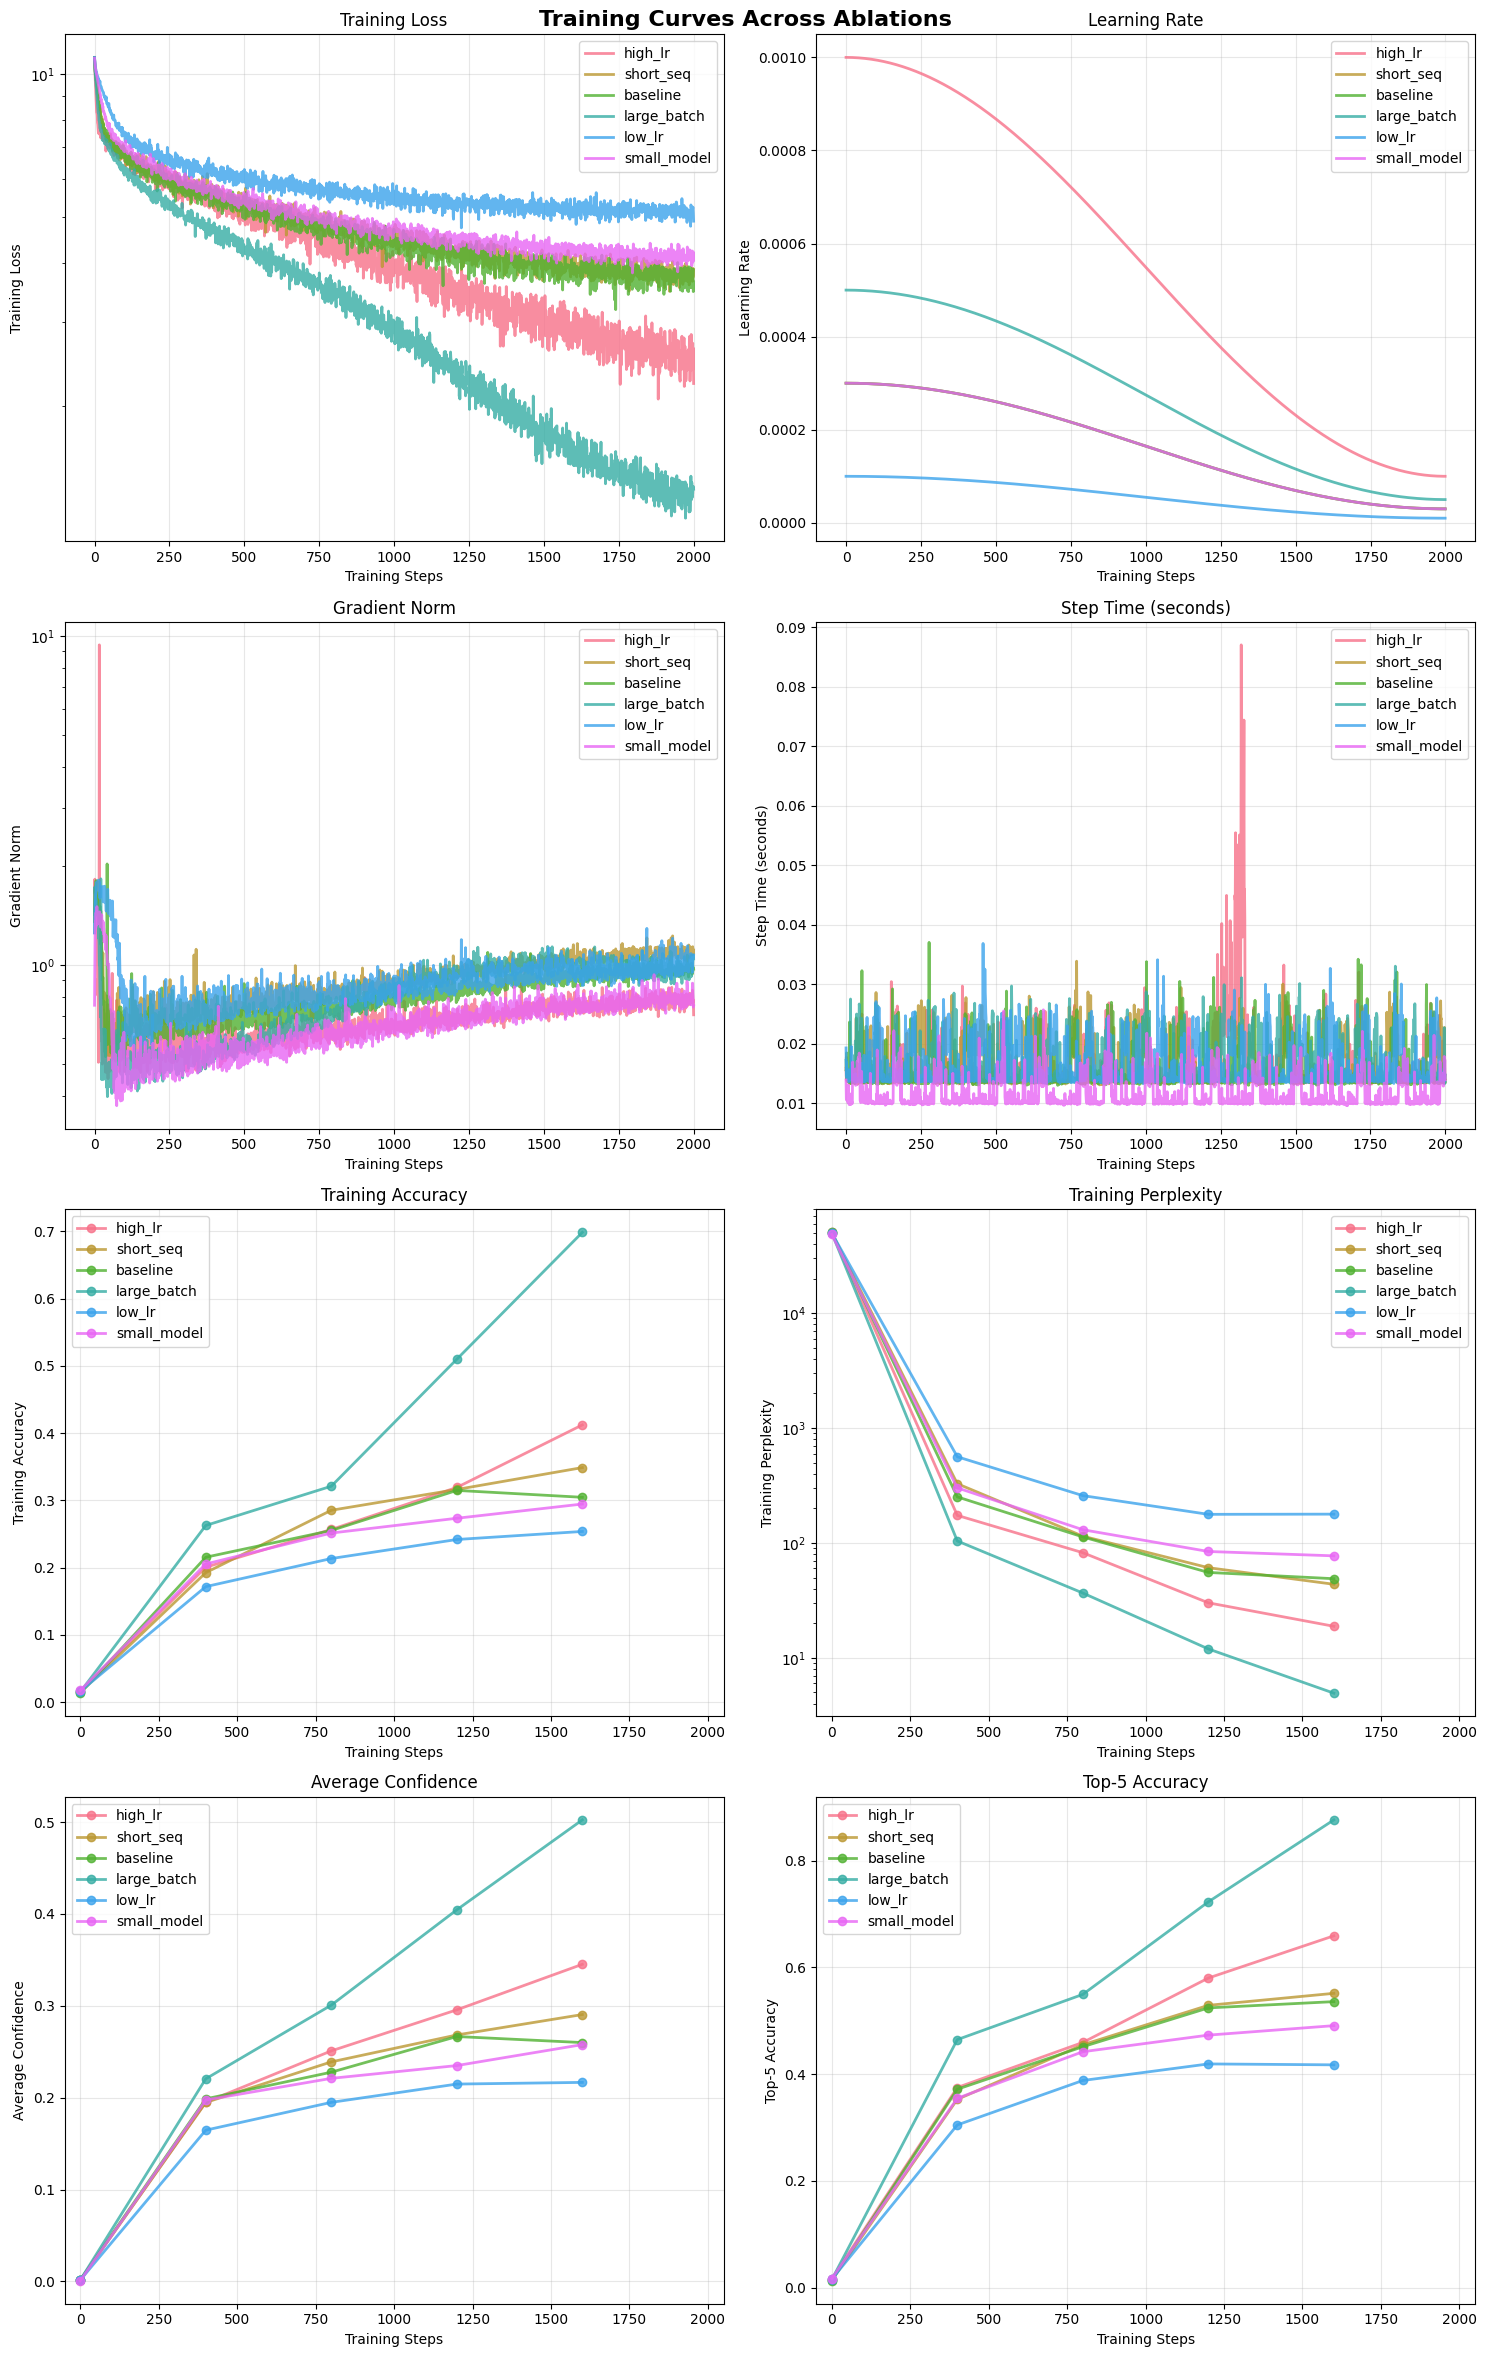

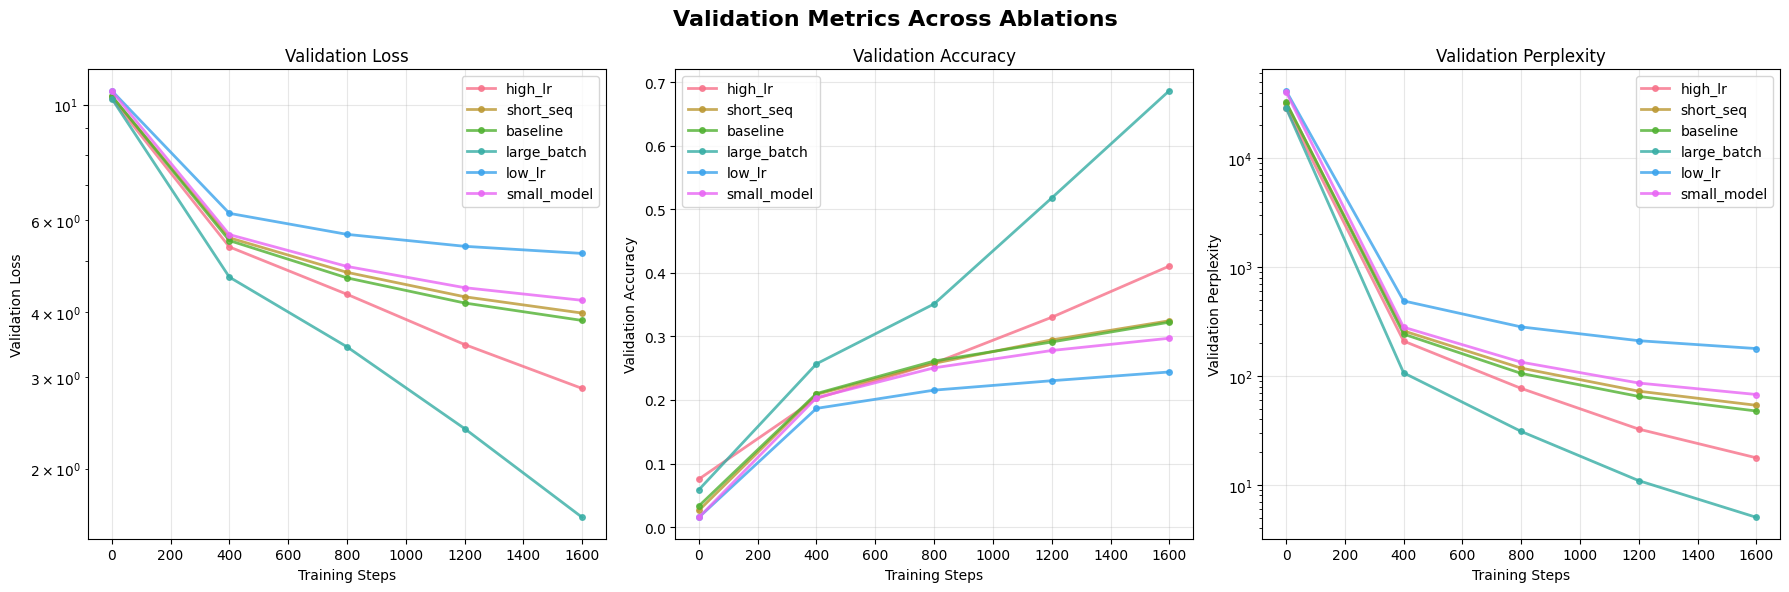

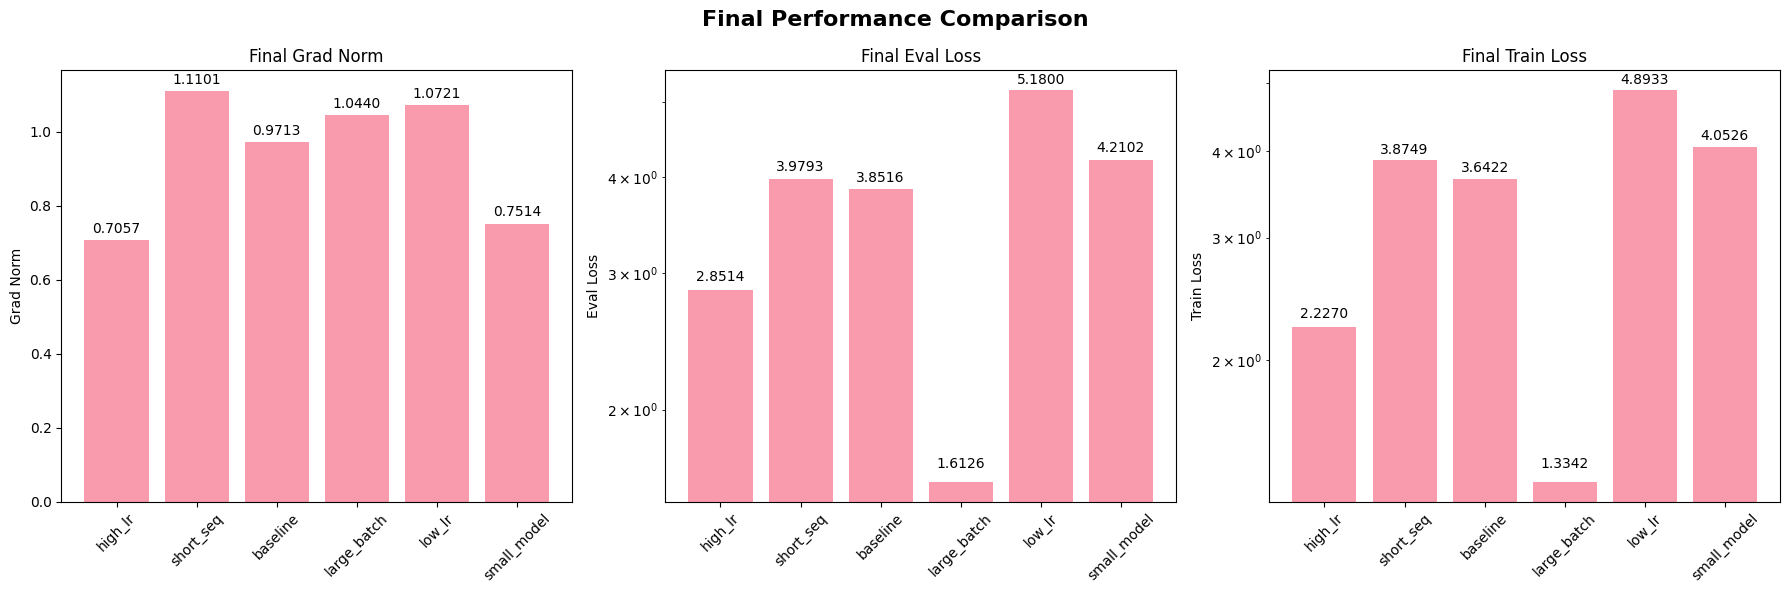

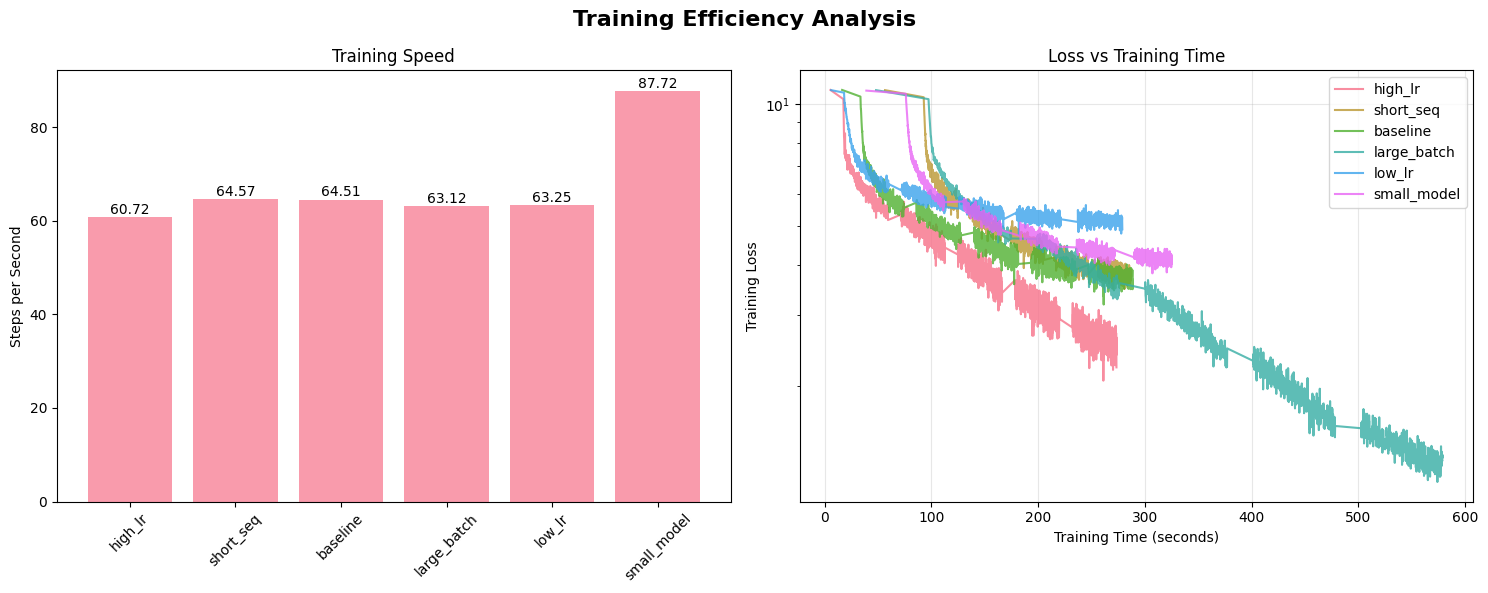


ABLATION STUDY SUMMARY REPORT

🏆 BEST PERFORMING CONFIG: large_batch
   Final Training Loss: 1.3342

📉 WORST PERFORMING CONFIG: low_lr
   Final Training Loss: 4.8933

📊 ALL FINAL LOSSES:
   large_batch: 1.3342
   high_lr: 2.2270
   baseline: 3.6422
   short_seq: 3.8749
   small_model: 4.0526
   low_lr: 4.8933

✅ All available plots generated!


In [ ]:
# Fixed Plotting for Enhanced Training Results
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os
from collections import defaultdict
import glob

# Set style
plt.style.use('default')  # Use default instead of seaborn-v0_8 for compatibility
sns.set_palette("husl")

class FixedAblationPlotter:
    def __init__(self, results_dir="training_logs"):
        self.results_dir = results_dir
        self.data = {}
        self.load_all_results()

    def load_all_results(self):
        """Load all ablation results with debugging"""
        print(f"Looking for results in: {self.results_dir}")

        if not os.path.exists(self.results_dir):
            print(f"❌ Results directory {self.results_dir} not found!")
            return

        for config_dir in glob.glob(f"{self.results_dir}/*/"):
            config_name = os.path.basename(config_dir.rstrip('/'))
            metrics_file = os.path.join(config_dir, "metrics.json")

            if os.path.exists(metrics_file):
                with open(metrics_file, 'r') as f:
                    data = json.load(f)
                    self.data[config_name] = data

                # Debug: show what metrics we actually have
                print(f"✅ Loaded {config_name}:")
                print(f"   Steps: {len(data.get('step', []))}")
                for key in data.keys():
                    if key != 'step':
                        values = data[key]
                        non_none_count = len([x for x in values if x is not None])
                        print(f"   {key}: {non_none_count} values out of {len(values)}")
                        if key in ['accuracy', 'perplexity', 'avg_confidence', 'top5_accuracy']:
                            print(f"     Sample values: {values[:10] if len(values) >= 10 else values}")
            else:
                print(f"❌ No metrics.json found in {config_dir}")

        if not self.data:
            print("❌ No training data found!")
        else:
            print(f"📊 Total configurations loaded: {len(self.data)}")

    def safe_get_metric(self, data, metric_name, skip_first_step_time=False):
        """Safely get metric values, filtering out None and handling special cases"""
        if metric_name not in data:
            return [], []

        values = data[metric_name]

        # Look for corresponding steps array
        steps_key = f"{metric_name}_steps"
        if steps_key in data:
            steps = data[steps_key]
        elif 'step' in data:  # Fallback to global step array
            steps = data['step']
        else:
            # No step information available, create sequential steps
            steps = list(range(len(values)))

        # Special handling for step_time - skip first value (kernel warmup)
        if metric_name == 'step_time' and skip_first_step_time and len(values) > 1:
            values = values[1:]
            steps = steps[1:len(values)+1] if len(steps) > len(values) else steps[1:]

        # Ensure steps and values have same length
        min_len = min(len(steps), len(values))
        steps = steps[:min_len]
        values = values[:min_len]

        # Filter out None, NaN, and inf values and align with steps
        valid_pairs = []
        for s, v in zip(steps, values):
            if v is not None and not (isinstance(v, float) and (np.isnan(v) or np.isinf(v))):
                valid_pairs.append((s, v))

        if not valid_pairs:
            return [], []

        valid_steps, valid_values = zip(*valid_pairs)
        return list(valid_steps), list(valid_values)

    def get_sparse_metric(self, data, metric_name):
        """Get metrics that are only logged at evaluation steps (every 400 steps)"""
        if metric_name not in data:
            return [], []

        values = data[metric_name]

        # Look for corresponding steps array
        steps_key = f"{metric_name}_steps"
        if steps_key in data:
            steps = data[steps_key]
        elif 'step' in data:  # Fallback to global step array
            steps = data['step']
        else:
            # No step information available, create sequential steps
            steps = list(range(len(values)))

        print(f"Debug {metric_name}: {len(values)} values, {len(steps)} steps")

        # Ensure steps and values have same length
        min_len = min(len(steps), len(values))
        steps = steps[:min_len]
        values = values[:min_len]

        # For sparse metrics, we expect fewer values, so just take all valid ones
        valid_pairs = []
        for s, v in zip(steps, values):
            if v is not None and not (isinstance(v, float) and (np.isnan(v) or np.isinf(v))):
                valid_pairs.append((s, v))
                print(f"Valid pair found: step {s}, value {v}")

        if not valid_pairs:
            print(f"No valid pairs found for {metric_name}")
            return [], []

        valid_steps, valid_values = zip(*valid_pairs)
        print(f"Returning {len(valid_steps)} points for {metric_name}: steps {valid_steps}")
        return list(valid_steps), list(valid_values)

    def plot_training_curves(self):
        """Plot available training curves"""
        # Check what metrics we actually have
        available_metrics = set()
        for config_name, data in self.data.items():
            available_metrics.update(data.keys())

        print(f"Available metrics: {available_metrics}")

        # Plot only metrics that exist - separate dense and sparse metrics
        dense_metrics = []  # Logged every step
        sparse_metrics = []  # Logged every 400 steps

        if 'train_loss' in available_metrics:
            dense_metrics.append(('train_loss', 'Training Loss', True))  # log scale
        if 'learning_rate' in available_metrics:
            dense_metrics.append(('learning_rate', 'Learning Rate', False))
        if 'grad_norm' in available_metrics:
            dense_metrics.append(('grad_norm', 'Gradient Norm', True))  # log scale
        if 'step_time' in available_metrics:
            dense_metrics.append(('step_time', 'Step Time (seconds)', False))

        # Sparse metrics (evaluation metrics)
        if 'accuracy' in available_metrics:
            sparse_metrics.append(('accuracy', 'Training Accuracy', False))
        if 'perplexity' in available_metrics:
            sparse_metrics.append(('perplexity', 'Training Perplexity', True))
        if 'avg_confidence' in available_metrics:
            sparse_metrics.append(('avg_confidence', 'Average Confidence', False))
        if 'top5_accuracy' in available_metrics:
            sparse_metrics.append(('top5_accuracy', 'Top-5 Accuracy', False))

        plot_metrics = dense_metrics + sparse_metrics

        if not plot_metrics:
            print("❌ No plottable training metrics found!")
            return

        n_plots = len(plot_metrics)
        cols = 2
        rows = (n_plots + 1) // 2

        fig, axes = plt.subplots(rows, cols, figsize=(15, 6*rows))
        if n_plots == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes
        else:
            axes = axes.flatten()

        fig.suptitle('Training Curves Across Ablations', fontsize=16, fontweight='bold')

        for idx, (metric, title, log_scale) in enumerate(plot_metrics):
            ax = axes[idx]

            for config_name, data in self.data.items():
                # Handle different metric types
                if metric in ['accuracy', 'perplexity', 'avg_confidence', 'top5_accuracy']:
                    # Sparse metrics - use dots connected by lines
                    steps, values = self.get_sparse_metric(data, metric)
                    if steps and values:
                        ax.plot(steps, values, label=config_name, alpha=0.8,
                               linewidth=2, marker='o', markersize=6)
                elif metric == 'step_time':
                    # Skip first step time (kernel warmup)
                    steps, values = self.safe_get_metric(data, metric, skip_first_step_time=True)
                    if steps and values:
                        ax.plot(steps, values, label=config_name, alpha=0.8, linewidth=2)
                else:
                    # Dense metrics - regular lines
                    steps, values = self.safe_get_metric(data, metric)
                    if steps and values:
                        ax.plot(steps, values, label=config_name, alpha=0.8, linewidth=2)

            ax.set_xlabel('Training Steps')
            ax.set_ylabel(title)
            ax.set_title(title)
            ax.legend()
            ax.grid(True, alpha=0.3)

            # Set proper x-axis limits for sparse metrics
            if metric in ['accuracy', 'perplexity', 'avg_confidence', 'top5_accuracy']:
                ax.set_xlim(-50, 2050)  # Show full training range

            if log_scale:
                ax.set_yscale('log')

        # Hide unused subplots
        for idx in range(n_plots, len(axes)):
            axes[idx].set_visible(False)

        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_validation_curves(self):
        """Plot validation metrics if available"""
        val_metrics = []
        available_metrics = set()
        for data in self.data.values():
            available_metrics.update(data.keys())

        if 'eval_loss' in available_metrics:
            val_metrics.append(('eval_loss', 'Validation Loss', True))
        if 'eval_accuracy' in available_metrics:
            val_metrics.append(('eval_accuracy', 'Validation Accuracy', False))
        if 'eval_perplexity' in available_metrics:
            val_metrics.append(('eval_perplexity', 'Validation Perplexity', True))

        if not val_metrics:
            print("❌ No validation metrics found!")
            return

        fig, axes = plt.subplots(1, len(val_metrics), figsize=(6*len(val_metrics), 6))
        if len(val_metrics) == 1:
            axes = [axes]

        fig.suptitle('Validation Metrics Across Ablations', fontsize=16, fontweight='bold')

        for idx, (metric, title, log_scale) in enumerate(val_metrics):
            ax = axes[idx]

            for config_name, data in self.data.items():
                steps, values = self.safe_get_metric(data, metric)
                if steps and values:
                    ax.plot(steps, values, label=config_name, alpha=0.8,
                           linewidth=2, marker='o', markersize=4)

            ax.set_xlabel('Training Steps')
            ax.set_ylabel(title)
            ax.set_title(title)
            ax.legend()
            ax.grid(True, alpha=0.3)

            if log_scale:
                ax.set_yscale('log')

        plt.tight_layout()
        plt.savefig('validation_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_final_comparison(self):
        """Plot final metrics comparison"""
        # Get final values for each config
        final_metrics = {}

        for config_name, data in self.data.items():
            final_metrics[config_name] = {}

            # Get final training loss
            if 'train_loss' in data and data['train_loss']:
                final_losses = [x for x in data['train_loss'] if x is not None]
                if final_losses:
                    final_metrics[config_name]['train_loss'] = final_losses[-1]

            # Get final validation loss
            if 'eval_loss' in data and data['eval_loss']:
                final_eval_losses = [x for x in data['eval_loss'] if x is not None]
                if final_eval_losses:
                    final_metrics[config_name]['eval_loss'] = final_eval_losses[-1]

            # Get final gradient norm
            if 'grad_norm' in data and data['grad_norm']:
                final_grad_norms = [x for x in data['grad_norm'] if x is not None]
                if final_grad_norms:
                    final_metrics[config_name]['grad_norm'] = final_grad_norms[-1]

        # Plot available final metrics
        available_final_metrics = set()
        for metrics in final_metrics.values():
            available_final_metrics.update(metrics.keys())

        if not available_final_metrics:
            print("❌ No final metrics available for comparison!")
            return

        n_metrics = len(available_final_metrics)
        fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 6))
        if n_metrics == 1:
            axes = [axes]

        fig.suptitle('Final Performance Comparison', fontsize=16, fontweight='bold')

        for idx, metric in enumerate(available_final_metrics):
            ax = axes[idx]

            configs = []
            values = []

            for config_name, metrics in final_metrics.items():
                if metric in metrics:
                    configs.append(config_name)
                    values.append(metrics[metric])

            if values:
                bars = ax.bar(configs, values, alpha=0.7)
                ax.set_ylabel(metric.replace('_', ' ').title())
                ax.set_title(f'Final {metric.replace("_", " ").title()}')
                ax.tick_params(axis='x', rotation=45)

                # Add value labels
                for bar, value in zip(bars, values):
                    ax.text(bar.get_x() + bar.get_width()/2,
                           bar.get_height() + max(values)*0.01,
                           f'{value:.4f}', ha='center', va='bottom', fontsize=10)

                if 'loss' in metric:
                    ax.set_yscale('log')

        plt.tight_layout()
        plt.savefig('final_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_training_efficiency(self):
        """Plot training efficiency"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle('Training Efficiency Analysis', fontsize=16, fontweight='bold')

        # Steps per second
        ax1 = axes[0]
        efficiency_data = {}

        for config_name, data in self.data.items():
            if 'step_time' in data and data['step_time']:
                step_times = data['step_time']
                # Skip first step time (kernel warmup) and filter valid times
                if len(step_times) > 1:
                    valid_times = [x for x in step_times[1:] if x is not None and x > 0 and x < 10]  # Skip outliers
                    if len(valid_times) > 5:
                        avg_step_time = np.mean(valid_times)
                        steps_per_sec = 1.0 / avg_step_time
                        efficiency_data[config_name] = steps_per_sec

        if efficiency_data:
            configs = list(efficiency_data.keys())
            values = list(efficiency_data.values())
            bars = ax1.bar(configs, values, alpha=0.7)
            ax1.set_ylabel('Steps per Second')
            ax1.set_title('Training Speed')
            ax1.tick_params(axis='x', rotation=45)

            for bar, value in zip(bars, values):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.2f}', ha='center', va='bottom')
        else:
            ax1.text(0.5, 0.5, 'No timing data available',
                    ha='center', va='center', transform=ax1.transAxes)

        # Loss vs Time
        ax2 = axes[1]
        plotted_any = False

        for config_name, data in self.data.items():
            if 'train_loss' in data:
                loss_steps, losses = self.safe_get_metric(data, 'train_loss')

                # Look for timestamps corresponding to train_loss
                timestamps_key = 'train_loss_timestamps'
                if timestamps_key in data:
                    timestamps = data[timestamps_key]
                elif 'timestamp' in data:  # Fallback to global timestamps
                    timestamps = data['timestamp']
                else:
                    timestamps = []

                if losses and timestamps:
                    # Ensure same length
                    min_len = min(len(losses), len(timestamps))
                    losses = losses[:min_len]
                    timestamps = timestamps[:min_len]

                    if timestamps and losses:
                        ax2.plot(timestamps, losses, label=config_name, alpha=0.8)
                        plotted_any = True

        if plotted_any:
            ax2.set_xlabel('Training Time (seconds)')
            ax2.set_ylabel('Training Loss')
            ax2.set_title('Loss vs Training Time')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            ax2.set_yscale('log')
        else:
            ax2.text(0.5, 0.5, 'No timing data available',
                    ha='center', va='center', transform=ax2.transAxes)

        plt.tight_layout()
        plt.savefig('training_efficiency.png', dpi=300, bbox_inches='tight')
        plt.show()

    def generate_summary_report(self):
        """Generate a summary report"""
        print("\n" + "="*60)
        print("ABLATION STUDY SUMMARY REPORT")
        print("="*60)

        # Final losses
        final_losses = {}
        for config_name, data in self.data.items():
            if 'train_loss' in data and data['train_loss']:
                losses = [x for x in data['train_loss'] if x is not None]
                if losses:
                    final_losses[config_name] = losses[-1]

        if final_losses:
            best_config = min(final_losses, key=final_losses.get)
            worst_config = max(final_losses, key=final_losses.get)

            print(f"\n🏆 BEST PERFORMING CONFIG: {best_config}")
            print(f"   Final Training Loss: {final_losses[best_config]:.4f}")

            print(f"\n📉 WORST PERFORMING CONFIG: {worst_config}")
            print(f"   Final Training Loss: {final_losses[worst_config]:.4f}")

            print(f"\n📊 ALL FINAL LOSSES:")
            for config, loss in sorted(final_losses.items(), key=lambda x: x[1]):
                print(f"   {config}: {loss:.4f}")

        print("\n" + "="*60)

    def plot_all(self):
        """Generate all available plots"""
        print("🎨 Generating plots based on available data...")

        if not self.data:
            print("❌ No data to plot!")
            return

        self.plot_training_curves()
        self.plot_validation_curves()
        self.plot_final_comparison()
        self.plot_training_efficiency()
        self.generate_summary_report()

        print("✅ All available plots generated!")

# For Colab usage:
def plot_training_results(results_dir="training_logs"):
    """Simple function to plot results in Colab"""
    plotter = FixedAblationPlotter(results_dir)
    plotter.plot_all()
    return plotter

if __name__ == "__main__":
    plotter = FixedAblationPlotter()
    plotter.plot_all()